In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# SPLITTING UP THE DATA HERE BASED ON A TSA APPROACH
### Other of our explorations might work slightly differently, if we do a prediction model or topic modeling

In [2]:
# df = pd.read_csv('npr_corpus.csv')
# df.head()

In [3]:
df = wrangle.get_npr_data()
df.head()

The df has 1889857 rows and 12 columns.


,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [4]:
df.shape

(1889857, 11)

In [5]:
df.speaker.value_counts()

neal conan                 255146
ira flatow                  73209
steve inskeep               59566
robert siegel               49750
melissa block               39984
                            ...  
steve halbrook                  1
claire feidler                  1
ms. asmaa almohamed             1
clap your hand say yeah         1
patidta kusongsaang             1
Name: speaker, Length: 105417, dtype: int64

In [6]:
# df.sort_values(by=['episode_id','episode_order'])[0:50]
df.sort_values(by=['story_id_num','utterance_order'])[0:50]

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
13231,17,1,melissa block,He is in cahoots with a foreign government to ...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,he is in cahoots with a foreign government to ...,he is in cahoot with a foreign government to m...,-0.8176,2019-09-22
13232,17,2,melissa block,Let's hear now from another Democrat. Tom Mali...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,let s hear now from another democrat. tom mali...,let s hear now from another democrat. tom mali...,0.4404,2019-09-22
13233,17,3,tom malinowski,Good morning.,weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,good morning .,good morning .,0.4404,2019-09-22
13234,17,4,melissa block,I'd like first to get your response to the Tru...,weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,i d like first to get your response to the tru...,i d like first to get your response to the tru...,0.3612,2019-09-22
13235,17,5,tom malinowski,"Well, first of all, it's illegal. We have a ve...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"well , first of all , it s illegal. we have a ...","well , first of all , it s illegal. we have a ...",0.8680,2019-09-22
13236,17,6,melissa block,"Now, we should explain that this has to do, ac...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"now , we should explain that this has to do , ...","now , we should explain that this ha to do , a...",0.5106,2019-09-22
13237,17,7,tom malinowski,"Look. I think there is a very, very big leap b...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"look. i think there is a very , very big leap ...","look. i think there is a very , very big leap ...",0.7783,2019-09-22
13238,17,8,melissa block,"And you say, if it's true...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"and you say , if it s true ...","and you say , if it s true ...",0.4215,2019-09-22
13239,17,9,tom malinowski,"And yes, impeachable.",weekend edition sunday,n.j. democrat on reported whistleblower compla...,False,"and yes , impeachable .","and yes , impeachable .",0.4019,2019-09-22
13240,17,10,melissa block,"You say, if it's true, what powers does the Ho...",weekend edition sunday,n.j. democrat on reported whistleblower compla...,True,"you say , if it s true , what powers does the ...","you say , if it s true , what power doe the ho...",0.4215,2019-09-22


## Ok, since we already have utterance order, we can just use that as a feature
## Moving on to utterance length

In [7]:
df.utterance[0]

"It's a 2,200-mile race. To give some sense of perspective, that's roughly the distance between Washington, D.C. and Las Vegas. They do it over the course of three weeks at very fast speeds. But incredibly, oftentimes the distance between first and second is somewhere between and one and three minutes."

In [8]:
len(df.utterance[0])

302

In [9]:
len(df.utterance[0].split())

50

In [10]:
# df.utterance.apply(str.split).apply(len)[0]

In [11]:
# df['utterance_length'] = len(df.utterance.split())
df['utterance_word_count'] = df.utterance.apply(str.split).apply(len)
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12,50
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12,87
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12,33
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12,118
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12,10


#### A quick lesson on .apply:

In [12]:
# def make_wordcloud(host):
#     etc etc

# h.apply(make_wordcloud)

# the h is what is referred to after the apply is applied

# or

# def make_wordcloud(host, ajowpj):
#     etc etc

# h.apply(make_wordcloud, extr_words= blah blah)

In [13]:
def string_cleaning(s):
    '''
    Function to remove punctuation from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z0-9'\s\?]", '', s)

    return s

In [14]:
df.utterance[2]

"So in every team, presumably there's one star, one equivalent to Lance Armstrong and the other team - the rest of the teammates project him, do what they can to help him succeed?"

In [15]:
# Series.str.contains(pat, case=True, flags=0, na=None, regex=True)

df.utterance.str.contains(r"[\?]", regex=True)[2]


# Ok, so this indicates thee presence of a question mark...how about a question mark count?

True

In [16]:
# pandas.Series.str.count

df.utterance.str.count(r"[\?]")[2]

1

In [17]:
df['question_mark_count'] = df.utterance.str.count(r"[\?]")
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,utterance_word_count,question_mark_count
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12,50,0
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12,87,0
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12,33,1
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12,118,0
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12,10,1


## Who asks the most questions?

In [18]:
df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,speaker,count
81830,neal conan,255146
29199,ira flatow,73209
98098,steve inskeep,59566
91806,robert siegel,49750
46070,melissa block,39984
89616,renee montagne,37241
23679,farai chideya,36719
94514,scott simon,33394
88612,rachel martin,31292
15210,david greene,30419


In [19]:
questions = df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

In [20]:
questions = questions.merge(df, how='left', on='speaker').drop(columns=['story_id_num', 'utterance_order', 'utterance',
       'title','clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'])
questions

,speaker,count,program,is_host,date
0,neal conan,255146,talk of the nation,True,2010-07-12
1,neal conan,255146,talk of the nation,True,2010-07-12
2,neal conan,255146,talk of the nation,True,2010-07-12
3,neal conan,255146,talk of the nation,True,2010-07-12
4,neal conan,255146,talk of the nation,True,2010-07-12
...,...,...,...,...,...
1889848,mr. jeff lipman,1,morning edition,False,2006-08-31
1889849,anne larigauderie,1,morning edition,False,2019-05-07
1889850,james delong,1,morning edition,False,2007-05-07
1889851,james delapp,1,morning edition,False,2017-10-11


Text(0, 0.5, 'Count of Questions')

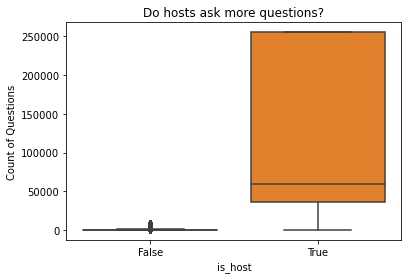

In [21]:
sns.boxplot(data= questions, x= 'is_host',y='count')
plt.title("Do hosts ask more questions?")
plt.ylabel("Count of Questions")

## Is there a difference in the mean sentiment by speaker? Program? etc
- Applied statistics-> i.e. stats testing. Is there a difference in the mean sentiment by speaker? Program? etc 

In [22]:
df.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader', 'date',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

In [23]:
df.shape

(1889857, 13)

In [24]:
df.dtypes

story_id_num              int64
utterance_order           int64
speaker                  object
utterance                object
program                  object
title                    object
is_host                    bool
clean                    object
lemmatized               object
vader                   float64
date                     object
utterance_word_count      int64
question_mark_count       int64
dtype: object

In [25]:
df.date = pd.to_datetime(df.date)

In [26]:
df.dtypes

story_id_num                     int64
utterance_order                  int64
speaker                         object
utterance                       object
program                         object
title                           object
is_host                           bool
clean                           object
lemmatized                      object
vader                          float64
date                    datetime64[ns]
utterance_word_count             int64
question_mark_count              int64
dtype: object

In [27]:

# df['Date'].dt.strftime('%b-%Y')

# df['episode_date'].dt.strftime('%b')

In [28]:
# df['month']=df['date'].dt.strftime('%b')
# df['year']=pd.DatetimeIndex(df['date']).year
# df=df.reset_index()
# df.head()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df=df.set_index('date').sort_index()

In [31]:
df = df[df.index.year >= 2005]

In [32]:
df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,85,neal conan,OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.296,1,0


In [33]:
train = df[:'2015']
validate = df['2016':'2017']
test = df['2018':]
train.shape, validate.shape, test.shape

((1665131, 12), (129513, 12), (95213, 12))

In [34]:
train.index[-1:], validate.index[:1], validate.index[-1:], test.index[:1]

(DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2016-01-01'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2017-12-29'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', name='date', freq=None))

<AxesSubplot:>

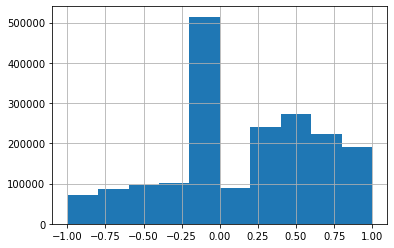

In [35]:
df.vader.hist()

## Using train split from here
##  This is mainly a tsa look

In [36]:
host_df = train[train.is_host==True]

In [37]:
guest_df = train[train.is_host!=True]

In [38]:
host_df.shape, guest_df.shape

((641017, 12), (1024114, 12))

In [39]:
host_df.shape

(641017, 12)

In [40]:
# are there repeats in the host_df? 
host_df.speaker.value_counts()

neal conan          255146
ira flatow           73209
robert siegel        43958
steve inskeep        41790
melissa block        38923
                     ...  
madeline brand           6
ray suarez               5
joost hiltermann         4
robert seigel            4
alison stewart           1
Name: speaker, Length: 86, dtype: int64

- I can see two different duplicates for steve inskeep bc of typos
- I think this is going to fall into the arena of significantly diminishing returns, and I will not address it at this time

In [41]:
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

- This is a list of the 12 hosts with the most observations

In [42]:
hosts_with_the_most

['neal conan',
 'ira flatow',
 'robert siegel',
 'steve inskeep',
 'melissa block',
 'farai chideya',
 'renee montagne',
 'scott simon',
 'david greene',
 'rachel martin']

In [43]:
top_hosts_df = train[train.speaker.isin(hosts_with_the_most)]


In [44]:
top_hosts_df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,85,neal conan,OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.296,1,0


In [45]:
top_hosts_df.index.min(), top_hosts_df.index.max()

(Timestamp('2005-01-11 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [46]:
top_hosts_df.vader.mean()

0.15754040663802443

- Here, we have the average sentiment score for all the top hosts; as you can see, it is relatively neutral in sentiment

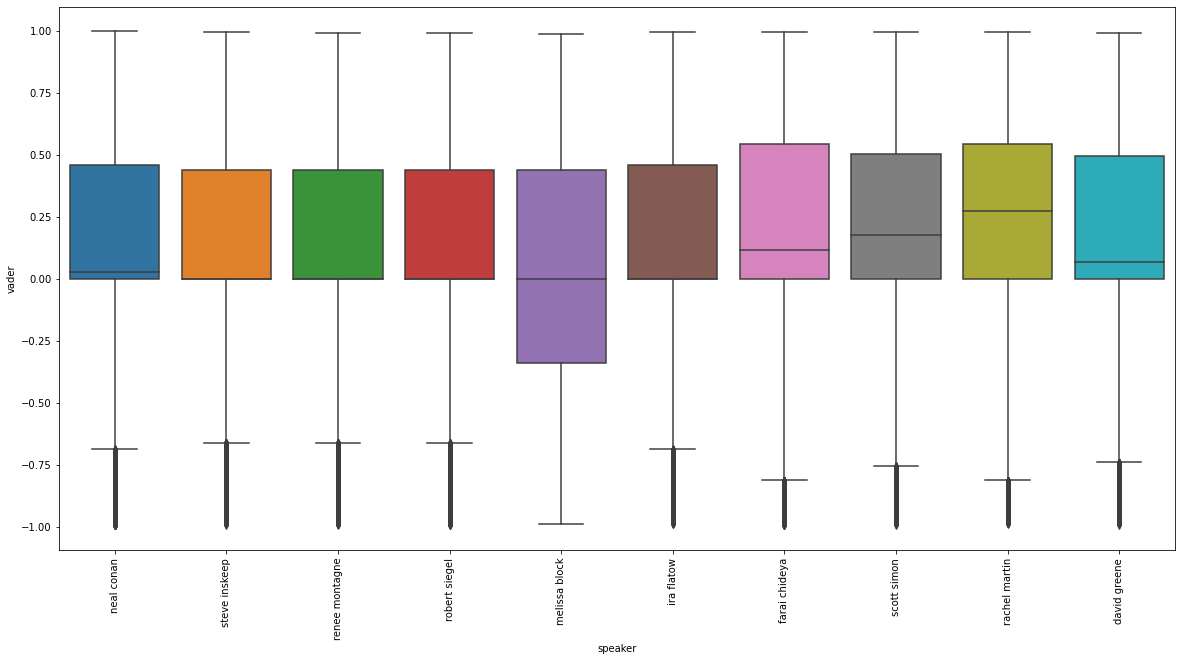

In [47]:
plt.figure(figsize=(20,10))
sns.boxplot(data=top_hosts_df, x='speaker',y='vader')
plt.xticks(rotation=90);

- The mean sentiment value is awfully close for everyone here, so i'm going to stats test it with an ANOVA test

In [48]:
null_hypothesis = "Average sentiment score is the same across hosts"
alternative_hypothesis = "Average sentiment score is different in at least one host of the group"
alpha = 0.01 # Let's be 99% certain the result we see isn't due to chance/randomness

In [49]:
host_df_list=[]
for host in hosts_with_the_most:
    x = host.split()
    host_df_list.append(f'{x[0]}_df')
print(host_df_list)

['neal_df', 'ira_df', 'robert_df', 'steve_df', 'melissa_df', 'farai_df', 'renee_df', 'scott_df', 'david_df', 'rachel_df']


In [50]:
hosts_with_the_most

['neal conan',
 'ira flatow',
 'robert siegel',
 'steve inskeep',
 'melissa block',
 'farai chideya',
 'renee montagne',
 'scott simon',
 'david greene',
 'rachel martin']

In [51]:
# Let's isolate our hosts
NEAL_df = train[train.speaker == 'neal conan'].vader
IRA_df = train[train.speaker ==  'ira flatow'].vader
ROBERT_df = train[train.speaker == 'robert siegel'].vader
STEVE_df = train[train.speaker == 'steve inskeep'].vader
MELISSA_df = train[train.speaker == 'melissa block'].vader
FARAI_df = train[train.speaker ==  'farai chideya'].vader
RENEE_df = train[train.speaker == 'renee montagne'].vader
SCOTT_df = train[train.speaker == 'scott simon'].vader
DAVID_df = train[train.speaker == 'david greene'].vader
RACHEL_df = train[train.speaker == 'rachel martin'].vader


# GUY_df = train[train.speaker == 'guy raz, host'].vader_stopped
# MADELEINE_df = train[train.speaker == 'madeleine brand, host'].vader_stopped
# MICHELE_df = train[train.speaker == 'michelle norris, host'].vader_stopped
# ALEX_df = train[train.speaker == 'alex chadwick, host'].vader_stopped


In [52]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(NEAL_df, IRA_df, ROBERT_df, STEVE_df, MELISSA_df, FARAI_df, RENEE_df, SCOTT_df, DAVID_df, RACHEL_df)
f, p

(678.8822392802028, 0.0)

In [53]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that Average sentiment score is the same across hosts
We move forward with the alternative hypothesis that Average sentiment score is different in at least one host of the group


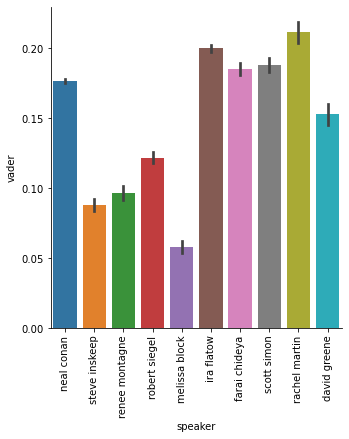

In [54]:
sns.catplot(x="speaker", y="vader", kind="bar", data=top_hosts_df)
plt.xticks(rotation=90);

- Another view of the same...it looks more clear here that there is a difference, however note the small scale on the y axis

In [55]:
top_hosts_df.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,85,neal conan,OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.296,1,0


### The conclusion to the above is that there is a statistically significant difference in sentiment in the top hosts group, even if it is small.

### Josh's code for the hosts' words

In [56]:
# host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['lemmatized'].agg(lambda col: ' '.join(col))

## What's the difference in sentiment score between hosts and non-hosts?

In [57]:
non_host_df = train[train.is_host==False]

Text(0, 0.5, 'Mean Sentiment Score')

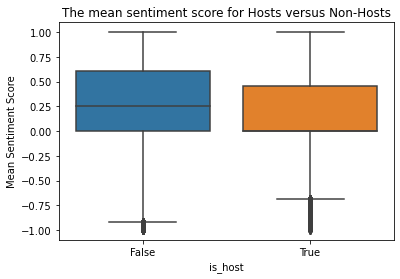

In [58]:
plt.figure
sns.boxplot(data=train, x='is_host',y='vader')
plt.title("The mean sentiment score for Hosts versus Non-Hosts")
plt.ylabel("Mean Sentiment Score")


In [59]:
train[train.is_host==False].vader.mean(), train[train.is_host==True].vader.mean()

(0.19270689337331326, 0.15284397605677771)

In [60]:
null_hypothesis = "Hosts and Non-hosts have the same sentiment score"
alternative_hypothesis = "Hosts and Non-hosts have different sentiment scores"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [61]:
#stats testing on the same
# anova is the wrong test!
from scipy import stats

t, p = stats.ttest_ind(host_df.vader,non_host_df.vader)
t, p

(-52.767792146270644, 0.0)

In [62]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print(f"Evidence does not support the claim that", alternate_hypothesis)

We reject the null hypothesis that Hosts and Non-hosts have the same sentiment score
We move forward with the hypothesis that Hosts and Non-hosts have different sentiment scores


### The average sentiment score for non-hosts is somewhat higher than for the hosts.  To be expected for a relatively neutral news outlet?

## How about sentiment score by year?

In [63]:
train.resample('Y').vader.mean()

date
2005-12-31    0.169318
2006-12-31    0.161386
2007-12-31    0.180956
2008-12-31    0.209603
2009-12-31    0.193803
2010-12-31    0.184554
2011-12-31    0.172069
2012-12-31    0.188927
2013-12-31    0.157618
2014-12-31    0.131946
2015-12-31    0.139144
Freq: A-DEC, Name: vader, dtype: float64

- why don't we have vader scores in 2000-2003 on yearly resampling?

In [64]:
vader_yearly = pd.DataFrame(train.resample('Y').vader.mean())

<AxesSubplot:xlabel='date'>

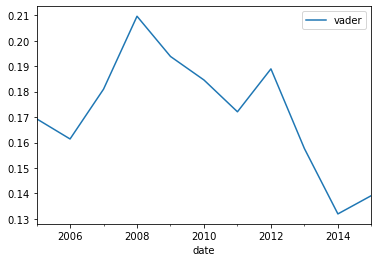

In [65]:
vader_yearly.plot()

In [66]:
whole_df_yearly = pd.DataFrame(df.resample('Y').vader.mean())

<AxesSubplot:xlabel='date'>

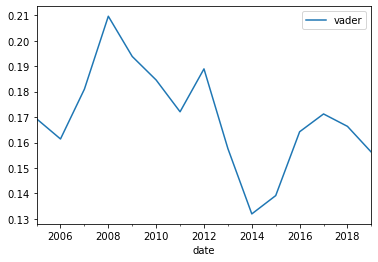

In [67]:
whole_df_yearly.plot()

In [68]:
vader_monthly = pd.DataFrame(train.resample('M').vader.mean())

In [69]:
vader_monthly.head()

,vader
date,
2005-01-31,0.272687
2005-02-28,NaN
2005-03-31,NaN
2005-04-30,NaN
2005-05-31,0.176331


<AxesSubplot:xlabel='date'>

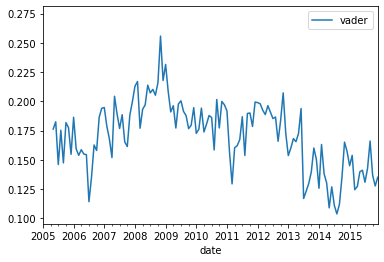

In [70]:
vader_monthly.plot()

- What's with all those missing sentiment scores in the early aughts?
- We eliminated observations pre-2005, they were missing data

In [71]:
# pd.DataFrame(df.resample("d").vader_stopped.mean()).plot()

## By day of week?

In [72]:
train.groupby(train.index.weekday).vader.mean()
# sentiment by day, 0 is monday, 6 is sunday

date
0    0.167613
1    0.166035
2    0.176345
3    0.173886
4    0.197642
5    0.182299
6    0.200146
Name: vader, dtype: float64

<AxesSubplot:xlabel='date', ylabel='vader'>

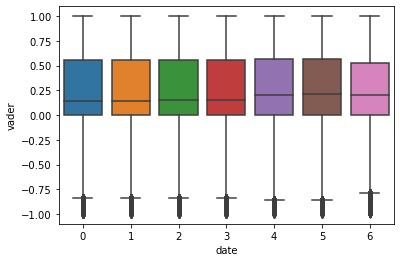

In [73]:
sns.boxplot(data=train, x=train.index.weekday,y='vader')

In [74]:
Monday_df = train[train.index.weekday == 0]
Tuesday_df = train[train.index.weekday == 1]
Wednesday_df = train[train.index.weekday == 2]
Thursday_df = train[train.index.weekday == 3]
Friday_df = train[train.index.weekday == 4]
Saturday_df = train[train.index.weekday == 5]
Sunday_df = train[train.index.weekday == 6]

In [75]:
null_hypothesis = "Different days of the week have the same sentiment score"
alternative_hypothesis = "At least one day of the week has a different sentiment score from the rest"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [76]:
from scipy.stats import f_oneway

f, p = f_oneway(Monday_df.vader,\
Tuesday_df.vader,\
Wednesday_df.vader,\
Thursday_df.vader,\
Friday_df.vader,\
Saturday_df.vader,\
Sunday_df.vader)

f, p

(167.5049242570386, 8.490168446994854e-214)

In [77]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from one weekday to the next")

We reject the null hypothesis that Different days of the week have the same sentiment score
We move forward with the alternative hypothesis that At least one day of the week has a different sentiment score from the rest


## And by program?

In [78]:
train.program.value_counts().index.to_list()

['talk of the nation',
 'morning edition',
 'all things considered',
 'news & notes',
 'weekend edition saturday',
 'weekend edition sunday',
 'day to day']

In [79]:
Talk_of_the_Nation_df = train[train.program == 'talk of the nation']
Morning_Edition_df = train[train.program == 'morning edition']
All_Things_Considered_df = train[train.program == 'all things considered']
News_and_Notes_df = train[train.program == 'news & notes']
Weekend_Edition_Saturday_df = train[train.program == 'weekend edition saturday']
Weekend_Edition_Sunday_df = train[train.program == 'weekend edition sunday']
Day_to_Day_df = train[train.program == 'day to day']


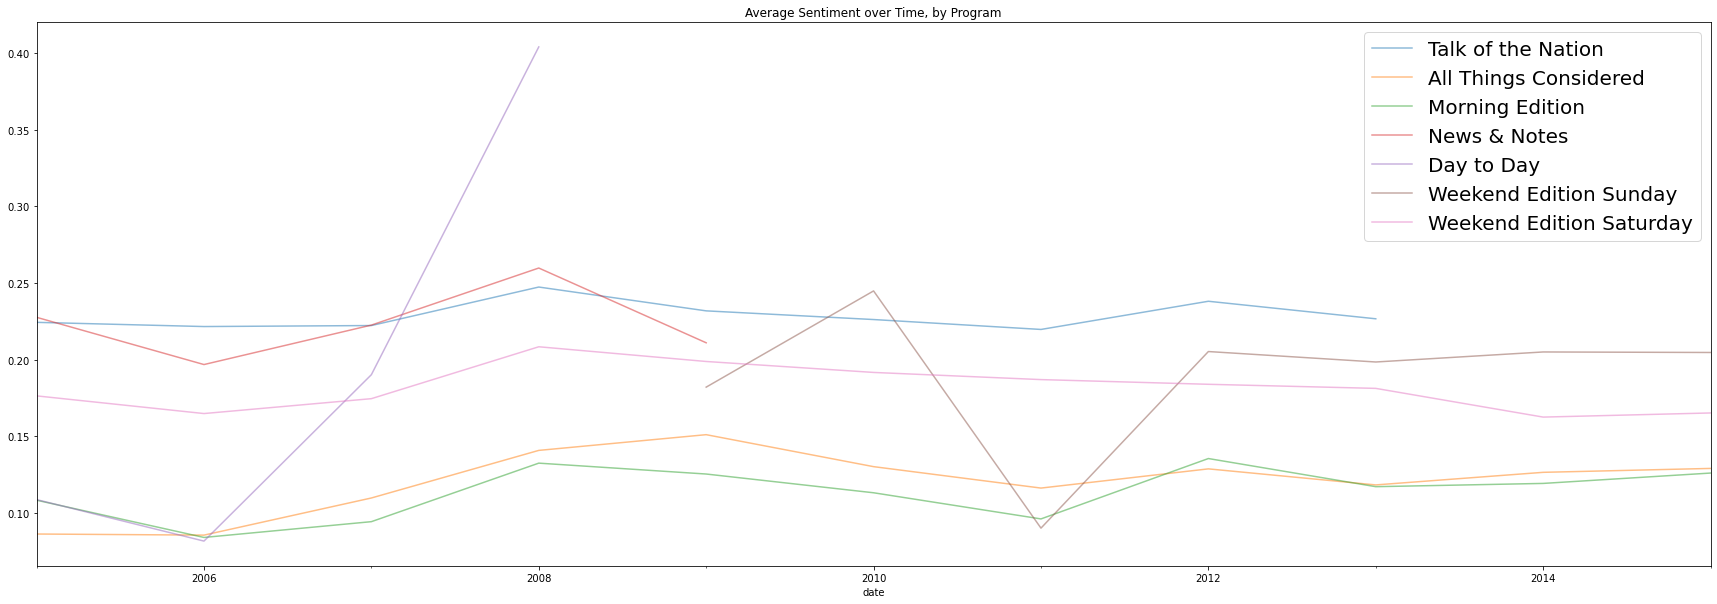

In [80]:
plt.figure(figsize=(30,10))
Talk_of_the_Nation_df.resample("y").vader.mean().plot(alpha=.5)
All_Things_Considered_df.resample("y").vader.mean().plot(alpha=.5)
Morning_Edition_df.resample("y").vader.mean().plot(alpha=.5)
News_and_Notes_df.resample("y").vader.mean().plot(alpha=.5)
Day_to_Day_df.resample("y").vader.mean().plot(alpha=.5)
Weekend_Edition_Sunday_df.resample("y").vader.mean().plot(alpha=.5)
Weekend_Edition_Saturday_df.resample("y").vader.mean().plot(alpha=.5)
plt.title("Average Sentiment over Time, by Program")
plt.legend(['Talk of the Nation',
 'All Things Considered',
 'Morning Edition',
 'News & Notes',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday'], prop={'size': 20})

- Note the programs that have gone off air
- Also, there is some difference in sentiment from program to program
- Weekend Edition (Sat and Sun) have higher sentiment scores--these programs try to be a little on the lighter side for the weekend
- We're definitely starting off the day on the most pessimistic note

In [81]:
null_hypothesis = "The different programs have the same sentiment score"
alternative_hypothesis = "At least one program has a different sentiment score"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [82]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(Talk_of_the_Nation_df.vader,
All_Things_Considered_df.vader,
Morning_Edition_df.vader,
News_and_Notes_df.vader,
Day_to_Day_df.vader,
Weekend_Edition_Sunday_df.vader,
Weekend_Edition_Saturday_df.vader,)
f, p

(3653.823957909019, 0.0)

In [83]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that The different programs have the same sentiment score
We move forward with the alternative hypothesis that At least one program has a different sentiment score


## How did sentiment change after 9/11 or etc...
- after obama election? 
- from start to finish of 2016 presidential campaign?

## what about clustering?
- There is very little continuous data here, clusering might not be possible.
- datetime...but how usefull can that be? 
- utterance order? is that available?
- maybe explor utterance order vs utterance length vs number of question marks or similar

In [84]:
train.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

In [85]:
train.sort_values(by=['story_id_num','utterance_order'])[0:50]

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2013-06-27,619,1,neal conan,"This is TALK OF THE NATION. I'm Neal Conan, in...",talk of the nation,what's the talk of your nation?,True,"this is talk of the nation. i m neal conan , i...","this is talk of the nation. i m neal conan , i...",0.6757,47,0
2013-06-27,619,2,neal conan,"On our last day, we think it's appropriate for...",talk of the nation,what's the talk of your nation?,True,"on our last day , we think it s appropriate fo...","on our last day , we think it s appropriate fo...",0.9034,81,2
2013-06-27,619,3,neal conan,And if you want to tell us what's the talk of ...,talk of the nation,what's the talk of your nation?,True,and if you want to tell us what s the talk of ...,and if you want to tell u what s the talk of t...,0.4215,40,0
2013-06-27,619,4,neal conan,And let's see if we can get Heather on the lin...,talk of the nation,what's the talk of your nation?,True,and let s see if we can get heather on the lin...,and let s see if we can get heather on the lin...,0.0000,16,0
2013-06-27,619,5,heather,"Hi, yes. I think one of the most important thi...",talk of the nation,what's the talk of your nation?,False,"hi , yes. i think one of the most important th...","hi , yes. i think one of the most important th...",0.6590,29,0
2013-06-27,619,6,neal conan,And the filibuster the other day by State Sena...,talk of the nation,what's the talk of your nation?,True,and the filibuster the other day by state sena...,and the filibuster the other day by state sena...,0.0000,11,0
2013-06-27,619,7,heather,"Right, which is absolutely incredible. She des...",talk of the nation,what's the talk of your nation?,False,"right , which is absolutely incredible. she de...","right , which is absolutely incredible. she de...",0.7713,26,0
2013-06-27,619,8,neal conan,And you know that the governor plans to call a...,talk of the nation,what's the talk of your nation?,True,and you know that the governor plans to call a...,and you know that the governor plan to call an...,0.7778,37,0
2013-06-27,619,9,heather,"I do know that, and I'm incredibly disappointe...",talk of the nation,what's the talk of your nation?,False,"i do know that , and i m incredibly disappoint...","i do know that , and i m incredibly disappoint...",-0.5256,15,0


### Ok, for the first time I'm seeing clearly how the episodes are in fact ordered by 'story' (episode_id) and then ordered by utterance within the story

### This is great, bc it's what is going to make topic modeling possible down the line

# First...
- Let's do a tsa model of sentiment using Prophet : )

In [86]:
train.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

In [87]:
for_tsa_modeling_df = pd.DataFrame(df['vader'])

In [88]:
for_tsa_modeling_df.head()

,vader
date,
2005-01-11,0.2960
2005-01-11,0.4019
2005-01-11,0.0000
2005-01-11,0.7906
2005-01-11,-0.8548


In [89]:
# for_prophet_df.resample('Y').mean()
for_tsa_modeling_df.index.year.value_counts()

2007    213708
2008    190844
2009    180095
2010    179388
2012    176305
2006    173052
2011    172823
2013    130009
2005    102972
2014     77886
2015     68049
2016     65271
2017     64242
2018     53154
2019     42059
Name: date, dtype: int64

- there is NOTHING in there fro 2000 to 2003
- 2004 barely a thing

In [90]:

tsa_train = for_tsa_modeling_df['2005':'2015']
tsa_validate = for_tsa_modeling_df['2016':'2017']
tsa_test = for_tsa_modeling_df['2018':]
tsa_train.shape, tsa_validate.shape, tsa_test.shape

((1665131, 1), (129513, 1), (95213, 1))

- I've dropped all observations prior to 2005 in this split due to the problem with the data

In [91]:
tsa_train[-1:], tsa_validate[:1], tsa_validate[-1:], tsa_test[:1]

(             vader
 date              
 2015-12-31  0.0129,
              vader
 date              
 2016-01-01  0.3818,
              vader
 date              
 2017-12-29  0.4019,
              vader
 date              
 2018-01-01  0.6597)

- the splits look good

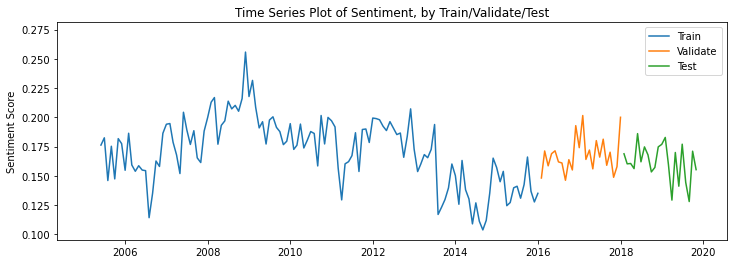

In [92]:
# for col in prophet_train.columns:
plt.figure(figsize=(12,4))
plt.plot(tsa_train.resample('M').vader.mean())
plt.plot(tsa_validate.resample('M').vader.mean())
plt.plot(tsa_test.resample('M').vader.mean())
plt.ylabel('Sentiment Score')
plt.title('Time Series Plot of Sentiment, by Train/Validate/Test')
plt.legend(labels = ["Train","Validate","Test"])
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

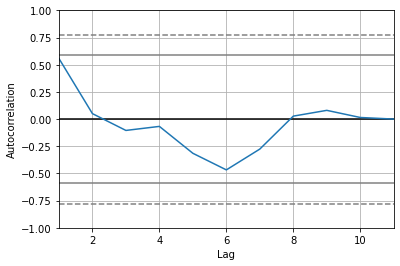

In [93]:
pd.plotting.autocorrelation_plot(tsa_train.resample('y').mean())

- There doesn't look to be any seasonality to speak of--try running the autocorrelation_plot with different resmample lengths
- from the curriculum:
    - "The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise."

In [94]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

<AxesSubplot:xlabel='date'>

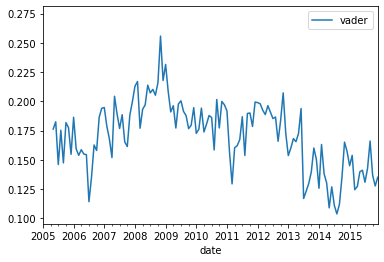

In [95]:
# prophet_train.dropna(axis=0, how='any')
tsa_train.dropna(axis=0, how='any').resample('M').mean().plot()

In [96]:
tsa_train[tsa_train.vader.isnull() == True]

,vader
date,


In [97]:
# tsa_train['vader_stopped'] = tsa_train['vader_stopped'].fillna(0)

In [98]:
# sm.tsa.seasonal_decompose(tsa_train.resample('M').mean()).plot()


# _ = sm.tsa.seasonal_decompose(tsa_train['vader_stopped'].resample('W').mean()).plot()


# ValueError: This function does not handle missing values


### Simple Average Model

In [99]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [100]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [101]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [102]:
score = round(tsa_train['vader'].mean(), 4)

def make_predictions():
    yhat_df = pd.DataFrame({'vader': score}, index = validate.index)

    return yhat_df

yhat_df = make_predictions()

In [103]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [104]:
# plot and evaluate 
def plot_and_eval_2(target_var,model_type):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(f"{target_var}, {model_type}")
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [105]:
yhat_df.head()

,vader
date,
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774
2016-01-01,0.1774


vader -- RMSE: 0.4786


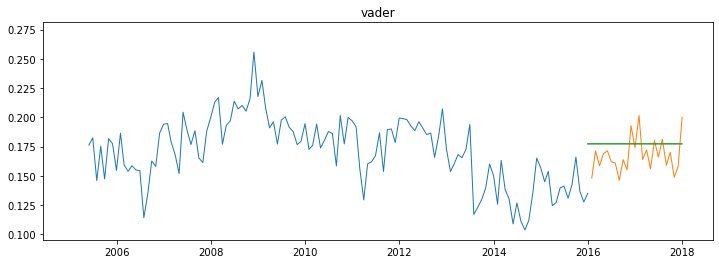

In [106]:
plot_and_eval('vader')

In [107]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'vader')

In [108]:
eval_df

,model_type,target_var,rmse
0,simple_average,vader,0.4786


### Moving Average

In [109]:
train['vader'].rolling(3).mean()

date
2005-01-11         NaN
2005-01-11         NaN
2005-01-11    0.232633
2005-01-11    0.397500
2005-01-11   -0.021400
                ...   
2015-12-31   -0.045567
2015-12-31   -0.261767
2015-12-31   -0.179800
2015-12-31    0.099500
2015-12-31    0.320000
Name: vader, Length: 1665131, dtype: float64

In [110]:
periods = [3, 6, 9, 12]

for p in periods:
    print(str(p) +'M')

3M
6M
9M
12M


vader -- RMSE: 0.4794


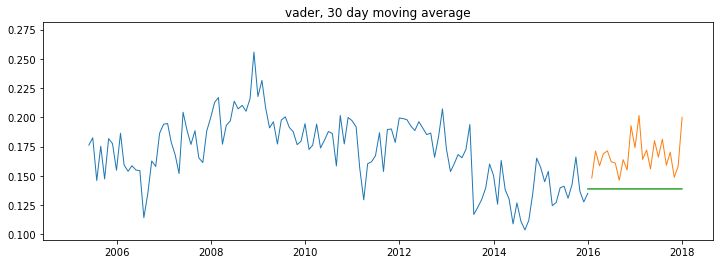

vader -- RMSE: 0.4800


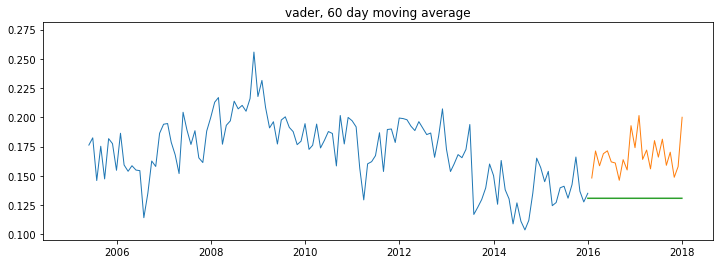

vader -- RMSE: 0.4797


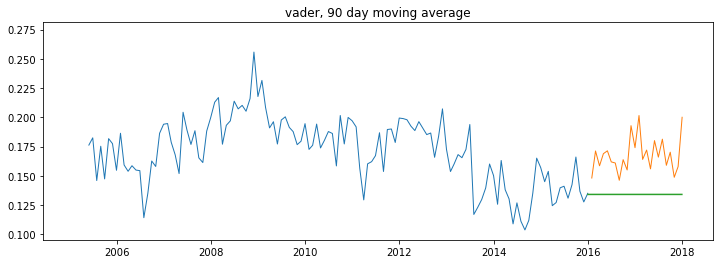

vader -- RMSE: 0.4794


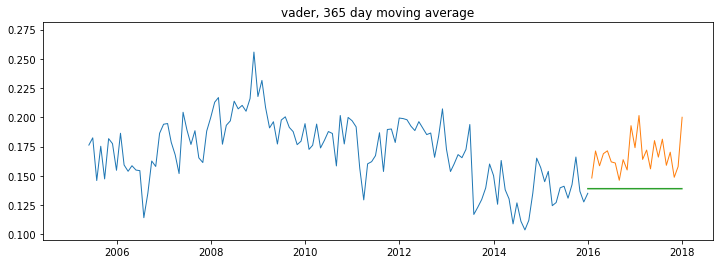

,model_type,target_var,rmse
0,simple_average,vader,0.4786
1,30 day moving average,vader,0.4794
2,60 day moving average,vader,0.4800
3,90 day moving average,vader,0.4797
4,365 day moving average,vader,0.4794


In [111]:
# Trying with different periods

periods = [30, 60, 90, 365]

for p in periods:
    score = round(tsa_train['vader'].rolling(str(p) +'D').mean().iloc[-1], 4)
    yhat_df = make_predictions()
    model_type = str(p) + ' day moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'vader'
                            )
    plot_and_eval_2('vader', model_type)
eval_df

In [112]:
yhat_df

,vader
date,
2016-01-01,0.1391
2016-01-01,0.1391
2016-01-01,0.1391
2016-01-01,0.1391
2016-01-01,0.1391
...,...
2017-12-29,0.1391
2017-12-29,0.1391
2017-12-29,0.1391


#### fixed the problem i was having with the rolling averages


In [113]:
# _ = sm.tsa.seasonal_decompose(train['vader'].resample('W').mean()).plot()
# plt.show()

# Still having problems loooking at seasonl decomposition due to missing valuese

In [114]:
tsa_validate.index[-1]

Timestamp('2017-12-29 00:00:00')

In [115]:
tsa_train['vader'].resample('M').mean()

date
2005-01-31    0.272687
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31    0.176331
                ...   
2015-08-31    0.142616
2015-09-30    0.166131
2015-10-31    0.136887
2015-11-30    0.127784
2015-12-31    0.135150
Freq: M, Name: vader, Length: 132, dtype: float64

In [116]:
# model = Holt(tsa_train['vader'], exponential = False)
# model = model.fit(smoothing_level = .1, 
#                   smoothing_slope = .1, 
#                   optimized = False)
# yhat_items = model.predict(start = tsa_validate.index[0], 
#                            end = tsa_validate.index[-1])
# yhat_df['vader'] = round(yhat_items, 4)

# #HOLTS IS BROKEN : (

# # KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'


In [117]:
# yhat_df.head()
# the above is returning NaNs only

In [118]:
# plot_and_eval('vader')

### Moving prophet model to its own notebook bc of the size of it (not pushing to github)

## The confidence intervals on the Prophet model were massive.  The sentiment observations in this data are very close together and yield rather little predictive power

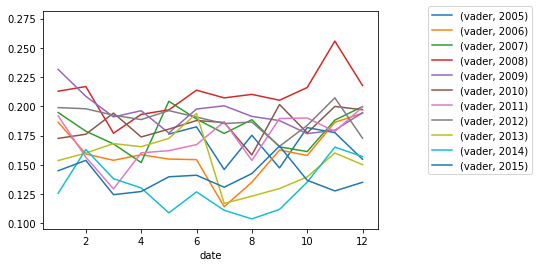

In [119]:
tsa_train.groupby([tsa_train.index.year, tsa_train.index.month]).mean().unstack(0).plot()
plt.legend(loc=(1.3,.5), bbox_to_anchor=(0.5, 0., 0.5, 0.5))

- Is there a trend of dipping sentiment in the summer?
- Also, it seems like the vader scores are lower in the later years

In [120]:
train.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2005-01-11,84432,85,neal conan,OK.,talk of the nation,difference between a think and a 'blink',True,ok .,ok .,0.2960,1,0
2005-01-11,84432,29,mr. malcolm gladwell,Yes.,talk of the nation,difference between a think and a 'blink',False,yes .,yes .,0.4019,1,0
2005-01-11,84432,30,gabriel,...the differences were taken for essence. I'...,talk of the nation,difference between a think and a 'blink',False,... the differences were taken for essence. i ...,... the difference were taken for essence. i l...,0.0000,13,0
2005-01-11,84432,31,neal conan,"OK, thanks for the call, Gabriel. Thanks.",talk of the nation,difference between a think and a 'blink',True,"ok , thanks for the call , gabriel. thanks .","ok , thanks for the call , gabriel. thanks .",0.7906,7,0
2005-01-11,84432,32,mr. malcolm gladwell,I think that's a really interesting and import...,talk of the nation,difference between a think and a 'blink',False,i think that s a really interesting and import...,i think that s a really interesting and import...,-0.8548,222,2


In [121]:
train.dtypes

story_id_num              int64
utterance_order           int64
speaker                  object
utterance                object
program                  object
title                    object
is_host                    bool
clean                    object
lemmatized               object
vader                   float64
utterance_word_count      int64
question_mark_count       int64
dtype: object

# MODELING

In [122]:
# THIS WAS HANDY CODE TO ELIMINATE SPEAKERS WITH ONLY 1 OR 2 OBSERVATIONS
# THOSE SPEAKERS WERE CREATING PROBLEMS WITH SPLITTING
# df.groupby('speaker').filter(lambda x : len(x)<=2) 

## In the next cell, i've sampled down the original df and derived all the splits based on 'rest', which was based on the small_df

In [123]:
small_df = df.sample(100_000, random_state=222)

counts = small_df['speaker'].value_counts()

rest = small_df[~small_df['speaker'].isin(counts[counts < 3].index)]
# df[df.groupby('speaker').filter(lambda x : len(x)<=2)] #this code doesn't work

# res works perfectly : ))))))))))))))

In [124]:
rest.head(1)

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,utterance_word_count,question_mark_count
date,,,,,,,,,,,,
2011-12-22,103360,6,sean carberry byline,"So far, there's nothing. No one has claimed re...",morning edition,wave of deadly explosions hit iraqi capital,False,"so far , there s nothing. no one has claimed r...","so far , there s nothing. no one ha claimed re...",-0.0382,67,0


In [125]:
df.shape,rest.shape

((1889857, 12), (75677, 12))

In [126]:
# rest.isna().sum()

## And split...

In [127]:
train, validate, test = wrangle.split_data(rest)
print(train.shape)
print(validate.shape)
print(test.shape)

(42378, 12)
(18163, 12)
(15136, 12)


In [128]:
train.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

In [129]:
features = train.drop(columns = ['story_id_num','speaker',\
                                 'utterance','program','title','is_host','clean','lemmatized']).columns.to_list()
features

['utterance_order', 'vader', 'utterance_word_count', 'question_mark_count']

In [130]:

# train, validate, test = wrangle.split_data(rest)
# print(train.shape)
# print(validate.shape)
# print(test.shape)


X_train = train[features]
y_train = train.is_host


X_validate = validate[features]
y_validate = validate.is_host


X_test = test[features]
y_test = test.is_host

In [131]:
train.shape, X_train.shape, validate.shape, X_validate.shape, test.shape, X_test.shape

((42378, 12), (42378, 4), (18163, 12), (18163, 4), (15136, 12), (15136, 4))

In [132]:
rest.question_mark_count.shape

(75677,)

In [133]:
rest.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

### BASELINE:


In [134]:
from sklearn.metrics import classification_report, accuracy_score

In [135]:
train.is_host.mode()

0    True
dtype: bool

In [136]:
df.is_host.mode()

0    False
dtype: bool

In [137]:
# create baseline on mode (is_host == True)
train['baseline_pred'] = True
validate['baseline_pred'] = True
test['baseline_pred'] = True

print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.baseline_pred)))
print('---')
print(classification_report(train.is_host, train.baseline_pred))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.baseline_pred)))
print('---')
print(classification_report(validate.is_host, validate.baseline_pred))

Train Accuracy: 50.06%
---
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     21163
        True       0.50      1.00      0.67     21215

    accuracy                           0.50     42378
   macro avg       0.25      0.50      0.33     42378
weighted avg       0.25      0.50      0.33     42378

Validate Accuracy: 50.06%
---
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      9070
        True       0.50      1.00      0.67      9093

    accuracy                           0.50     18163
   macro avg       0.25      0.50      0.33     18163
weighted avg       0.25      0.50      0.33     18163



# Logistic Regression

### Using ONLY features (no tfidf/bow)

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))


lm = LogisticRegression().fit(X_train, y_train)

train['predicted_X_train_just_features'] = lm.predict(X_train)
validate['predicted_X_validate_just_features'] = lm.predict(X_validate)
test['predicted_X_test_just_features'] = lm.predict(X_test)

In [143]:
print('Train Accuracy, Tfidf Train: {:.2%}'.format(accuracy_score(train.actual, train.predicted_X_train_just_features)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Tfidf Validate: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_X_validate_just_features)))
print(classification_report(train.actual, train.predicted_X_train_just_features))


Train Accuracy, Tfidf Train: 62.65%
---
Validate Accuracy, Tfidf Validate: 62.29%
              precision    recall  f1-score   support

       False       0.63      0.59      0.61     21163
        True       0.62      0.66      0.64     21215

    accuracy                           0.63     42378
   macro avg       0.63      0.63      0.63     42378
weighted avg       0.63      0.63      0.63     42378



### On TF-IDF, No additional features

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer()


In [147]:
Xtfidf = tfidf.fit_transform(rest.lemmatized) # is this a problem? to fit on the whole df? 
#instead of just X? Been meaning to ask a while, this is from lesson. 
# Ryan clarified: the vecorizers are trained on the whole df, just not the models.

ytfidf = rest.is_host

Xtfidf_train, Xtfidf_test, ytfidf_train, ytfidf_test = train_test_split(Xtfidf, ytfidf, stratify=ytfidf, \
                                                                        test_size=.2)
Xtfidf_train, Xtfidf_validate, ytfidf_train, ytfidf_validate = train_test_split(\
                                                Xtfidf_train,ytfidf_train,stratify=ytfidf_train, test_size=.2)

train = pd.DataFrame(dict(actual=ytfidf_train))
validate = pd.DataFrame(dict(actual=ytfidf_validate))
test = pd.DataFrame(dict(actual=ytfidf_test))

lm = LogisticRegression().fit(Xtfidf_train, ytfidf_train)

train['predicted_Xtfidf'] = lm.predict(Xtfidf_train)
validate['predicted_Xtfidf'] = lm.predict(Xtfidf_validate)
test['predicted_Xtfidf'] = lm.predict(Xtfidf_test)

In [148]:
print('Train Accuracy, Tfidf Train: {:.2%}'.format(accuracy_score(train.actual, train.predicted_Xtfidf)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Tfidf Validate: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_Xtfidf)))
print(classification_report(train.actual, train.predicted_Xtfidf))


Train Accuracy, Tfidf Train: 80.64%
---
Validate Accuracy, Tfidf Validate: 74.27%
              precision    recall  f1-score   support

       False       0.79      0.84      0.81     24186
        True       0.83      0.78      0.80     24246

    accuracy                           0.81     48432
   macro avg       0.81      0.81      0.81     48432
weighted avg       0.81      0.81      0.81     48432



### On TF-IDF, With additional features

In [149]:
# Attempting to add other feature columns to the sparse array using scipy.sparse.hstack

import scipy as sp
# np.reshape(new_col,(len(new_col),1))
Xtfidf_plusfeatures = sp.sparse.hstack((Xtfidf, pd.DataFrame(rest.question_mark_count),pd.DataFrame(rest.utterance_order),
                                       pd.DataFrame(rest.vader),pd.DataFrame(rest.utterance_word_count)))

# Xtfidf = sp.sparse.hstack((Xtfidf, pd.DataFrame(rest.utterance_order)))
# Xtfidf = sp.sparse.hstack((Xtfidf, pd.DataFrame(rest.vader)))
# Xtfidf = sp.sparse.hstack((Xtfidf, pd.DataFrame(rest.utterance_word_count)))
print(Xtfidf_plusfeatures.shape)

(75677, 51122)


In [150]:
ytfidf_plusfeatures = rest.is_host

Xtfidf_train_plusfeatures, Xtfidf_test_plusfeatures, ytfidf_train_plusfeatures, ytfidf_test_plusfeatures = train_test_split(Xtfidf, ytfidf, stratify=ytfidf, \
                                                                        test_size=.2)
Xtfidf_train_plusfeatures, Xtfidf_validate_plusfeatures, ytfidf_train_plusfeatures, ytfidf_validate_plusfeatures = train_test_split(\
                                                Xtfidf_train_plusfeatures,ytfidf_train_plusfeatures,stratify=ytfidf_train_plusfeatures, test_size=.2)

train = pd.DataFrame(dict(actual=ytfidf_train_plusfeatures))
validate = pd.DataFrame(dict(actual=ytfidf_validate_plusfeatures))
test = pd.DataFrame(dict(actual=ytfidf_test_plusfeatures))

lm = LogisticRegression().fit(Xtfidf_train_plusfeatures, ytfidf_train_plusfeatures)

train['predicted_Xtfidf_train_plusfeatures'] = lm.predict(Xtfidf_train_plusfeatures)
validate['predicted_Xtfidf_validate_plusfeatures'] = lm.predict(Xtfidf_validate_plusfeatures)
test['predicted_Xtfidf_test_plusfeatures'] = lm.predict(Xtfidf_test_plusfeatures)


In [151]:
print('Train Accuracy, Tfidf_PlusFeatures Train: {:.2%}'.format(accuracy_score(train.actual, train.predicted_Xtfidf_train_plusfeatures)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Tfidf_PlusFeatures Validate: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_Xtfidf_validate_plusfeatures)))
print(classification_report(train.actual, train.predicted_Xtfidf_train_plusfeatures))


Train Accuracy, Tfidf_PlusFeatures Train: 80.58%
---
Validate Accuracy, Tfidf_PlusFeatures Validate: 74.19%
              precision    recall  f1-score   support

       False       0.79      0.83      0.81     24186
        True       0.82      0.78      0.80     24246

    accuracy                           0.81     48432
   macro avg       0.81      0.81      0.81     48432
weighted avg       0.81      0.81      0.81     48432



In [152]:

# classification_report(train.actual, train.predicted)

### On Count Vectorizer (aka Bag of Words), No additional features

In [153]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

In [154]:
Xcv= cv.fit_transform(rest.lemmatized)

ycv = rest.is_host

Xcv_train, Xcv_test, ycv_train, ycv_test = train_test_split(Xcv, ycv, stratify=ycv, test_size=.2)
Xcv_train, Xcv_validate, ycv_train, ycv_validate = train_test_split(Xcv_train, ycv_train, stratify=ycv_train, test_size=.2)



train = pd.DataFrame(dict(actual=ycv_train))
validate = pd.DataFrame(dict(actual=ycv_validate))
test = pd.DataFrame(dict(actual=ycv_test))

lm = LogisticRegression().fit(Xcv_train, ycv_train)

train['predicted_Xcv_train'] = lm.predict(Xcv_train)
validate['predicted_Xcv_validate'] = lm.predict(Xcv_validate)
test['predicted_Xcv_test'] = lm.predict(Xcv_test)

In [155]:
print('Train Accuracy, Countvectorizer: {:.2%}'.format(accuracy_score(train.actual, train.predicted_Xcv_train)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Countvectorizer: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_Xcv_validate)))
print(classification_report(train.actual, train.predicted_Xcv_train))


Train Accuracy, Countvectorizer: 84.30%
---
Validate Accuracy, Countvectorizer: 72.67%
              precision    recall  f1-score   support

       False       0.85      0.83      0.84     24186
        True       0.83      0.86      0.85     24246

    accuracy                           0.84     48432
   macro avg       0.84      0.84      0.84     48432
weighted avg       0.84      0.84      0.84     48432



### On Count Vectorizer (aka Bag of Words), with additional features

In [156]:
Xcv_plus_features = sp.sparse.hstack((Xcv, pd.DataFrame(rest.question_mark_count),\
                                      pd.DataFrame(rest.utterance_order), pd.DataFrame(rest.vader), \
                                      pd.DataFrame(rest.utterance_word_count)))

ycv_plus_features = rest.is_host

Xcv_train_plus_features, Xcv_test_plus_features, ycv_train_plus_features, \
ycv_test_plus_features = train_test_split(Xcv_plus_features, ycv_plus_features, stratify=ycv_plus_features, test_size=.2)

Xcv_train_plus_features, Xcv_validate_plus_features, ycv_train_plus_features, \
ycv_validate_plus_features = train_test_split(Xcv_train_plus_features, ycv_train_plus_features, stratify=ycv_train_plus_features, test_size=.2)

train = pd.DataFrame(dict(actual=ycv_train_plus_features))
validate = pd.DataFrame(dict(actual=ycv_validate_plus_features))
test = pd.DataFrame(dict(actual=ycv_test_plus_features))

lm = LogisticRegression().fit(Xcv_train_plus_features, ycv_train_plus_features)

train['predicted_Xcv_train_plus_features'] = lm.predict(Xcv_train_plus_features)
validate['predicted_Xcv_validate_plus_features'] = lm.predict(Xcv_validate_plus_features)
test['predicted_Xcv_test_plus_features'] = lm.predict(Xcv_test_plus_features)


In [157]:
print('Train Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(train.actual, train.predicted_Xcv_train_plus_features)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Countvectorizer_PlusFeatures: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_Xcv_validate_plus_features)))
print(classification_report(train.actual, train.predicted_Xcv_train_plus_features))


Train Accuracy, Countvectorizer_PlusFeatures: 74.55%
---
Validate Accuracy, Countvectorizer_PlusFeatures: 72.86%
              precision    recall  f1-score   support

       False       0.74      0.76      0.75     24186
        True       0.76      0.73      0.74     24246

    accuracy                           0.75     48432
   macro avg       0.75      0.75      0.75     48432
weighted avg       0.75      0.75      0.75     48432



## Great, so far we have 4 models built on Logistic Regression, one is a Bag Of Words and the other is a TF-IDF.  


## Decision Tree, JUST Features, no nlp methods

-- Mult hyperparameters could be tried
-- Create splits again, they've been manipulated above

In [158]:
features = rest.drop(columns = ['story_id_num','speaker',\
                                 'utterance','program','title','is_host','clean','lemmatized']).columns.to_list()


train, validate, test = wrangle.split_data(rest)
print(train.shape)
print(validate.shape)
print(test.shape)


X_train = train[features]
y_train = train.is_host


X_validate = validate[features]
y_validate = validate.is_host


X_test = test[features]
y_test = test.is_host

print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(42378, 12)
(18163, 12)
(15136, 12)
(42378, 4)
(18163, 4)
(15136, 4)
(42378,)
(18163,)
(15136,)


In [159]:
features

['utterance_order', 'vader', 'utterance_word_count', 'question_mark_count']

In [160]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5, random_state = 222)

In [161]:
train.columns

Index(['story_id_num', 'utterance_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized', 'vader',
       'utterance_word_count', 'question_mark_count'],
      dtype='object')

In [162]:
clf_just_features = clf.fit(X_train, y_train)
train['predicted_clf_just_features'] = clf.predict(X_train)

validate['predicted_clf_just_features'] = clf.predict(X_validate)

In [164]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.is_host, train.predicted_clf_just_features)))
print('---')
print(classification_report(train.is_host, train.predicted_clf_just_features))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.is_host, validate.predicted_clf_just_features)))
print('---')
print(classification_report(validate.is_host, validate.predicted_clf_just_features))


Train Accuracy: 68.16%
---
              precision    recall  f1-score   support

       False       0.64      0.81      0.72     21163
        True       0.74      0.55      0.64     21215

    accuracy                           0.68     42378
   macro avg       0.69      0.68      0.68     42378
weighted avg       0.69      0.68      0.68     42378

Validate Accuracy: 68.27%
---
              precision    recall  f1-score   support

       False       0.64      0.82      0.72      9070
        True       0.75      0.55      0.63      9093

    accuracy                           0.68     18163
   macro avg       0.70      0.68      0.68     18163
weighted avg       0.70      0.68      0.68     18163



## Decision Tree, TFIDF NO Features

-- Mult hyperparameters could be tried

In [178]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5, random_state = 222)

In [179]:
Xtfidf = tfidf.fit_transform(rest.lemmatized)

ytfidf = rest.is_host

Xtfidf_train, Xtfidf_test, ytfidf_train, ytfidf_test = train_test_split(Xtfidf, ytfidf, stratify=ytfidf, \
                                                                        test_size=.2)
Xtfidf_train, Xtfidf_validate, ytfidf_train, ytfidf_validate = train_test_split(\
                                                Xtfidf_train,ytfidf_train,stratify=ytfidf_train, test_size=.2)

train = pd.DataFrame(dict(actual=ytfidf_train))
validate = pd.DataFrame(dict(actual=ytfidf_validate))
test = pd.DataFrame(dict(actual=ytfidf_test))

lm = LogisticRegression().fit(Xtfidf_train, ytfidf_train)

train['predicted_Xtfidf'] = lm.predict(Xtfidf_train)
validate['predicted_Xtfidf'] = lm.predict(Xtfidf_validate)
test['predicted_Xtfidf'] = lm.predict(Xtfidf_test)

In [180]:
Xtfidf = tfidf.fit_transform(rest.lemmatized)

ytfidf = rest.is_host

Xtfidf_train, Xtfidf_test, ytfidf_train, ytfidf_test = train_test_split(Xtfidf, ytfidf, stratify=ytfidf, \
                                                                        test_size=.2)
Xtfidf_train, Xtfidf_validate, ytfidf_train, ytfidf_validate = train_test_split(\
                                                Xtfidf_train,ytfidf_train,stratify=ytfidf_train, test_size=.2)

train = pd.DataFrame(dict(actual=ytfidf_train))
validate = pd.DataFrame(dict(actual=ytfidf_validate))
test = pd.DataFrame(dict(actual=ytfidf_test))


clf_tfidf = clf.fit(Xtfidf_train, ytfidf_train)


train['predicted_clf_tfidf'] = clf.predict(Xtfidf_train)
validate['predicted_clf_tfidf'] = clf.predict(Xtfidf_validate)
test['predicted_clf_tfidf'] = clf.predict(Xtfidf_test)

In [181]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_clf_tfidf)))
print('---')
print(classification_report(train.actual, train.predicted_clf_tfidf))

print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_clf_tfidf)))
print('---')
print(classification_report(validate.actual, validate.predicted_clf_tfidf))


Train Accuracy: 62.84%
---
              precision    recall  f1-score   support

       False       0.71      0.43      0.54     24186
        True       0.59      0.83      0.69     24246

    accuracy                           0.63     48432
   macro avg       0.65      0.63      0.61     48432
weighted avg       0.65      0.63      0.61     48432

Validate Accuracy: 62.44%
---
              precision    recall  f1-score   support

       False       0.70      0.43      0.53      6047
        True       0.59      0.82      0.69      6062

    accuracy                           0.62     12109
   macro avg       0.65      0.62      0.61     12109
weighted avg       0.65      0.62      0.61     12109



## Decision Tree,  TF-IDF PLUS Features

In [215]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 3, random_state = 222)

In [216]:
Xtfidf = tfidf.fit_transform(rest.lemmatized)

ytfidf = rest.is_host

Xtfidf_plusfeatures = sp.sparse.hstack((Xtfidf, pd.DataFrame(rest.question_mark_count),pd.DataFrame(rest.utterance_order),
                                       pd.DataFrame(rest.vader),pd.DataFrame(rest.utterance_word_count)))

ytfidf_plusfeatures = rest.is_host

Xtfidf_train_plusfeatures, Xtfidf_test_plusfeatures, ytfidf_train_plusfeatures, ytfidf_test_plusfeatures = train_test_split(Xtfidf, ytfidf, stratify=ytfidf, \
                                                                        test_size=.2)
Xtfidf_train_plusfeatures, Xtfidf_validate_plusfeatures, ytfidf_train_plusfeatures, ytfidf_validate_plusfeatures = train_test_split(\
                                                Xtfidf_train_plusfeatures,ytfidf_train_plusfeatures,stratify=ytfidf_train_plusfeatures, test_size=.2)

train = pd.DataFrame(dict(actual=ytfidf_train_plusfeatures))
validate = pd.DataFrame(dict(actual=ytfidf_validate_plusfeatures))
test = pd.DataFrame(dict(actual=ytfidf_test_plusfeatures))

clf_tfidf = clf.fit(Xtfidf_train_plusfeatures, ytfidf_train_plusfeatures)

train['CLF_predicted_Xtfidf_train_plusfeatures'] = lm.predict(Xtfidf_train_plusfeatures)
validate['CLF_predicted_Xtfidf_validate_plusfeatures'] = lm.predict(Xtfidf_validate_plusfeatures)
test['CLF_predicted_Xtfidf_test_plusfeatures'] = lm.predict(Xtfidf_test_plusfeatures)
print(Xtfidf_plusfeatures.shape)

(75677, 51122)


In [217]:
print('Train Accuracy, Tfidf_PlusFeatures Train: {:.2%}'.format(accuracy_score(train.actual, train.CLF_predicted_Xtfidf_train_plusfeatures)))
print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
print('Validate Accuracy, Tfidf_PlusFeatures Validate: {:.2%}'.format(accuracy_score(validate.actual, validate.CLF_predicted_Xtfidf_validate_plusfeatures)))
print(classification_report(train.actual, train.CLF_predicted_Xtfidf_train_plusfeatures))


Train Accuracy, Tfidf_PlusFeatures Train: 78.21%
---
Validate Accuracy, Tfidf_PlusFeatures Validate: 78.69%
              precision    recall  f1-score   support

       False       0.77      0.81      0.79     24186
        True       0.80      0.75      0.78     24246

    accuracy                           0.78     48432
   macro avg       0.78      0.78      0.78     48432
weighted avg       0.78      0.78      0.78     48432

